# Purpose: to predict the hardness of a material with a regression model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import ElasticNet, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

## Functions

In [2]:
def plot_histograms(data_df: pd.DataFrame):
    ''' 
    Plot histogram of all variables in the training set
    '''
    fig, axes = plt.subplots(3,4)
    for i, column in enumerate(data_df.columns):
        sns.histplot(
            x=data_df[column], 
            ax=axes[i // 4, i % 4]
            )
    plt.tight_layout()

def plot_scatter(data_df: pd.DataFrame):
    fig, axes = plt.subplots(3,4)
    for i, column in enumerate(data_df.columns):
        sns.scatterplot(
            x=data_df[column], 
            y=data_df['Hardness'], 
            ax=axes[i // 4, i % 4], 
            s=5, 
            alpha=0.5
        )
    plt.tight_layout()
    

## Inspect the provided training data

In [3]:
data_df=pd.read_csv('train.csv', index_col='id')
display(data_df.head())

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [4]:
data_df.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


In [5]:
print(f"number nan measurements: {data_df.isna().sum().sum()}")

number nan measurements: 0


### Data visualization

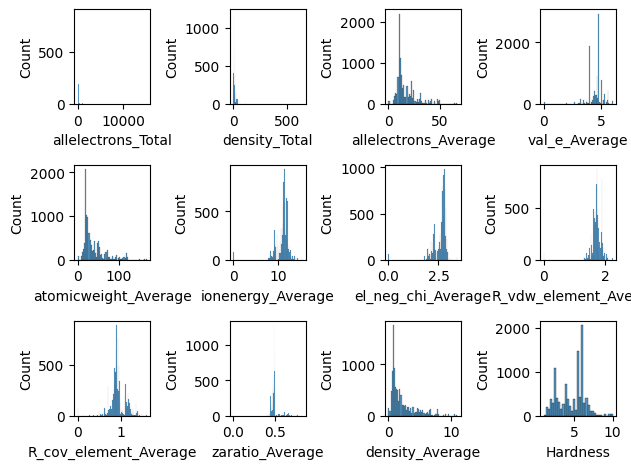

In [6]:
plot_histograms(data_df)

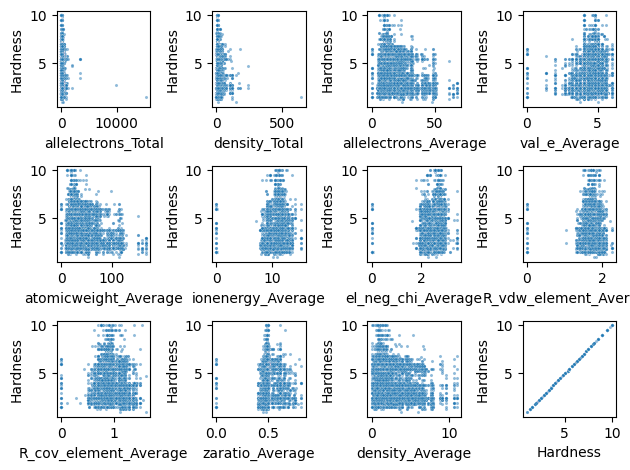

In [7]:
plot_scatter(data_df)

While there are no NaN values, many points do lie at 0, suggesting they are missing data.

In [8]:
print(f"number measurements = 0: {(data_df==0).sum()}")
(data_df==0).sum(axis=1).sort_values(ascending=False).head(10)

number measurements = 0: allelectrons_Total       76
density_Total            54
allelectrons_Average     76
val_e_Average            71
atomicweight_Average     77
ionenergy_Average        73
el_neg_chi_Average       67
R_vdw_element_Average    68
R_cov_element_Average    77
zaratio_Average          62
density_Average          56
Hardness                  0
dtype: int64


id
2643    10
3278    10
8477    10
7564    10
8757    10
6068    10
7105    10
8116    10
751     10
8889    10
dtype: int64

### Removing samples with 10 values == 0

In [9]:
data_df_cleaned=data_df.loc[(data_df==0).sum(axis=1)<5]
data_df_cleaned.shape


(10329, 12)

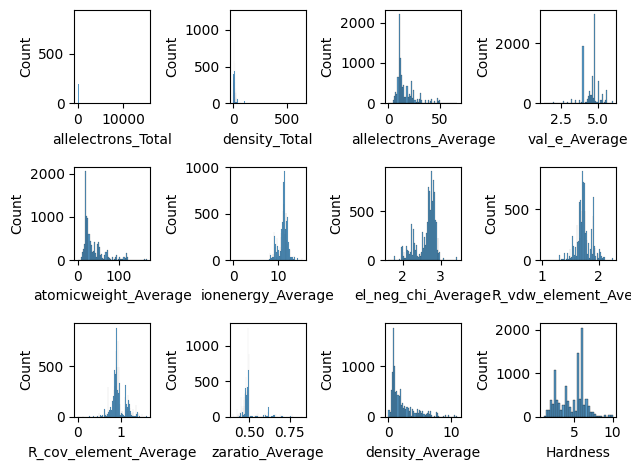

In [10]:
plot_histograms(data_df_cleaned)

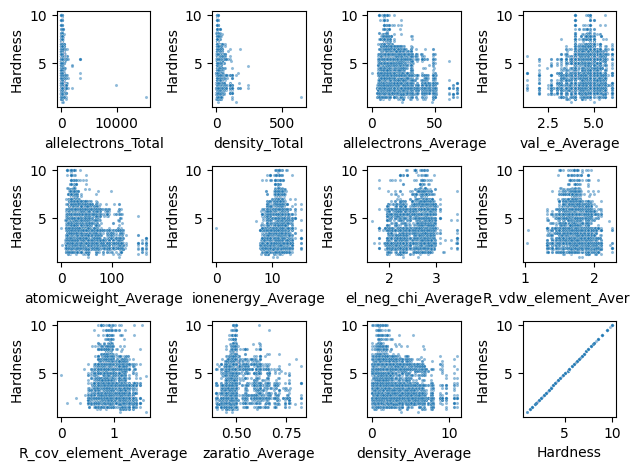

In [11]:
plot_scatter(data_df_cleaned)

In [12]:
data_df_cleaned.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10329.000000,10329.000000,10329.00000,10329.000000,10329.000000,10329.000000,10329.000000,10329.000000,10329.000000,10329.000000,10329.000000,10329.000000
mean,129.016065,14.599458,17.16043,4.578510,37.790095,11.017298,2.625116,1.742671,0.951043,0.496301,2.145289,4.661685
std,224.693193,15.984339,10.40439,0.580833,25.905643,1.059462,0.260420,0.132051,0.161328,0.050391,1.938530,1.671638
min,0.001000,0.001000,0.00100,1.333333,0.001000,0.000167,1.622865,1.028000,0.000000,0.401635,0.000000,1.000000
25%,68.000000,7.558488,10.00000,4.000000,20.298893,10.599905,2.530000,1.672500,0.865000,0.476196,0.817390,3.000000
50%,100.000000,10.803992,12.60000,4.750000,26.203827,11.217767,2.706000,1.733958,0.918000,0.488550,1.363050,5.500000
75%,131.000000,16.676996,22.00000,4.800000,48.719500,11.683233,2.805000,1.811562,0.982500,0.496167,2.780220,6.000000
max,15300.000000,643.093804,67.00000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


## Prepare data for modeling

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data_df_cleaned.drop('Hardness', axis=1), 
    data_df_cleaned['Hardness'],
    test_size=0.33
)
print(f"number training samples: {len(y_train)}")
print(f"number test samples: {len(y_test)}")

number training samples: 6920
number test samples: 3409


KstestResult(statistic=0.01653647180109774, pvalue=0.5526965956144868)

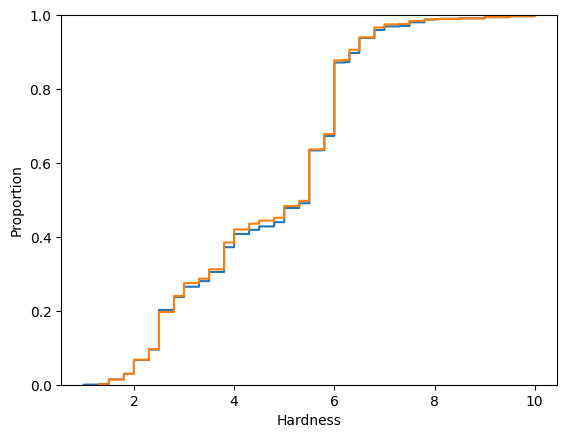

In [14]:
sns.ecdfplot(y_train)
sns.ecdfplot(y_test)

stats.ks_2samp(y_train, y_test)

## Baseline model
Starting with elastic net for penalized regression
Using 10-fold CV

In [15]:
params = {
    'alpha': np.logspace(-4, 4, 9),
    'l1_ratio': np.arange(0, 1.2, 0.2)
}

enet=GridSearchCV(
    estimator=ElasticNet(),
    param_grid=params, 
    cv=10,
    return_train_score=True,
    scoring='neg_median_absolute_error'
)

enet.fit(X_train, y_train)

/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.307e+03, tolerance: 1.740e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.302e+03, tolerance: 1.740e+00 Linear regression models with null weight for the l1 regular

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])},
             return_train_score=True, scoring='neg_median_absolute_error')

<Axes: xlabel='param_l1_ratio', ylabel='mean_test_score'>

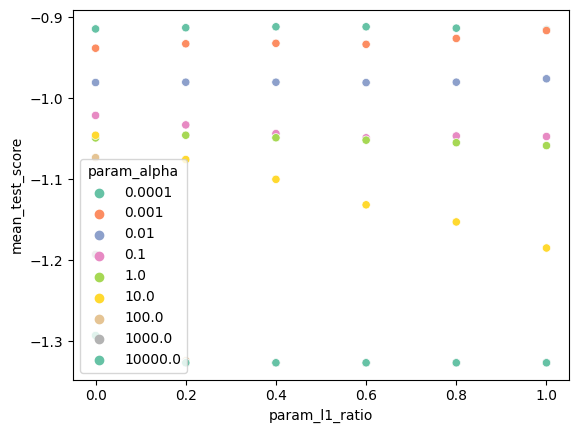

In [16]:
enet_results=pd.DataFrame(enet.cv_results_)

sns.scatterplot(
    x=enet_results['param_l1_ratio'],
    y=enet_results['mean_test_score'],
    hue=enet_results['param_alpha'],
    palette='Set2'
)

In [17]:
y_pred=cross_val_predict(
    estimator=enet.best_estimator_,
    cv=10,
    X=X_train,
    y=y_train
)

Text(37.722222222222214, 0.5, 'predicted hardness')

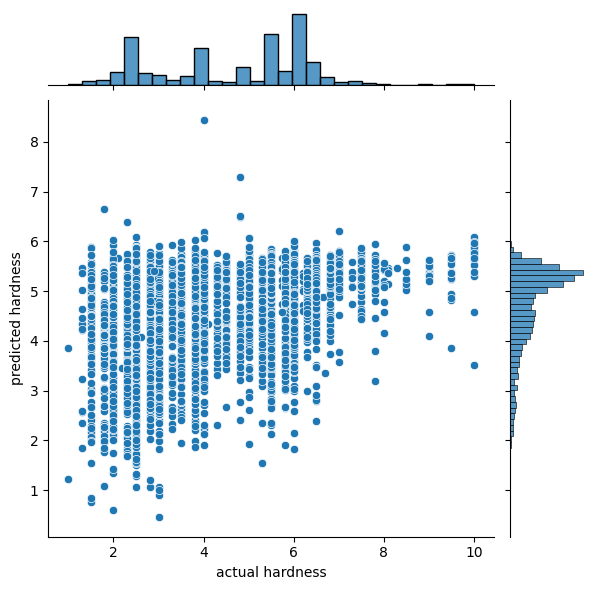

In [18]:
sns.jointplot(x=y_train, y=y_pred)
plt.xlabel('actual hardness')
plt.ylabel('predicted hardness')

## Random forest regressor

In [19]:
params = {
    'n_estimators': [10, 100, 1000],
    'max_features': [None, 'sqrt', 'log2'],
}

rfr=GridSearchCV(
    estimator=RandomForestRegressor(
        oob_score=True
    ),
    param_grid=params, 
    cv=10,
    scoring='neg_median_absolute_error',
    n_jobs=2
)

rfr.fit(X_train, y_train)

/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 

GridSearchCV(cv=10, estimator=RandomForestRegressor(oob_score=True), n_jobs=2,
             param_grid={'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='neg_median_absolute_error')

<Axes: xlabel='param_n_estimators', ylabel='mean_test_score'>

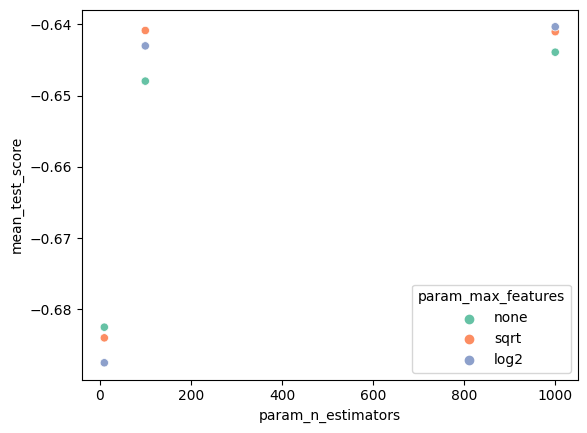

In [20]:
rfr_results=pd.DataFrame(rfr.cv_results_)
rfr_results.head()
rfr_results=rfr_results.fillna('none')

sns.scatterplot(
    x=rfr_results['param_n_estimators'],
    y=rfr_results['mean_test_score'],
    hue=rfr_results['param_max_features'],
    palette='Set2'
)

In [21]:
y_pred=cross_val_predict(
    estimator=rfr.best_estimator_,
    cv=10,
    X=X_train,
    y=y_train
)

Text(37.722222222222214, 0.5, 'predicted hardness')

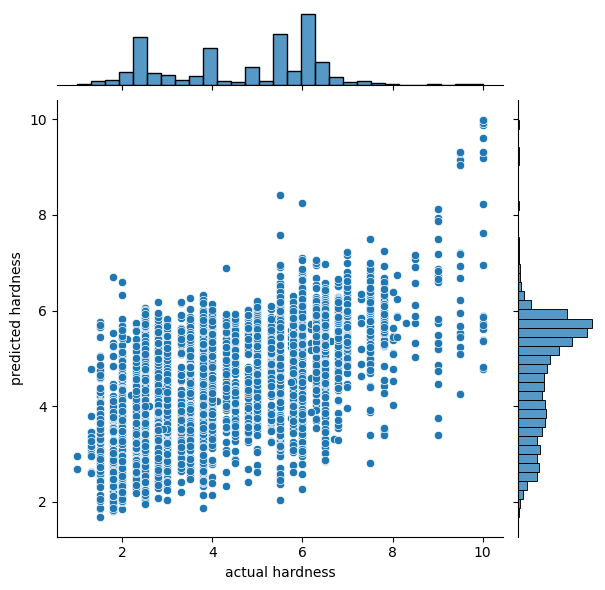

In [22]:
sns.jointplot(x=y_train, y=y_pred)
plt.xlabel('actual hardness')
plt.ylabel('predicted hardness')

## Try logistic regression
Mohs scale is ordinal, not linear. Logistic regression could work better

In [23]:
params = {
    'C': np.logspace(-2, 2, 5),
    'l1_ratio': np.arange(0, 1.2, 0.2)
}

logr=GridSearchCV(
    estimator=LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        multi_class='multinomial'
    ),
    param_grid=params, 
    cv=10,
    return_train_score=True,
    scoring='neg_median_absolute_error'
)

logr.fit(X_train, pd.Categorical(round(y_train).astype(int)))

/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/li

GridSearchCV(cv=10,
             estimator=LogisticRegression(multi_class='multinomial',
                                          penalty='elasticnet', solver='saga'),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])},
             return_train_score=True, scoring='neg_median_absolute_error')

In [24]:
logr_results=pd.DataFrame(logr.cv_results_)
logr_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.402516,0.008612,0.001666,0.000227,0.01,0.0,"{'C': 0.01, 'l1_ratio': 0.0}",-1.0,-1.0,-0.0,...,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.90,0.30
1,0.538560,0.015921,0.001589,0.000239,0.01,0.2,"{'C': 0.01, 'l1_ratio': 0.2}",-1.0,-1.0,-0.0,...,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.90,0.30
2,0.521340,0.012059,0.001798,0.000390,0.01,0.4,"{'C': 0.01, 'l1_ratio': 0.4}",-1.0,-1.0,-0.5,...,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.90,0.30
3,0.542647,0.015121,0.001958,0.000446,0.01,0.6,"{'C': 0.01, 'l1_ratio': 0.6000000000000001}",-1.0,-1.0,-0.0,...,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.90,0.30
4,0.522062,0.021570,0.001735,0.000261,0.01,0.8,"{'C': 0.01, 'l1_ratio': 0.8}",-1.0,-1.0,-0.5,...,-1.0,-1.0,-0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-0.95,0.15


<Axes: xlabel='param_l1_ratio', ylabel='mean_test_score'>

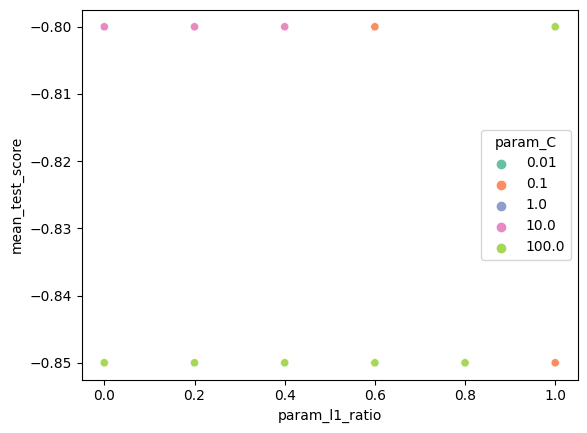

In [25]:
sns.scatterplot(
    x=logr_results['param_l1_ratio'],
    y=logr_results['mean_test_score'],
    hue=logr_results['param_C'],
    palette='Set2'
)

In [26]:
logr_pred=cross_val_predict(
    estimator=logr.best_estimator_,
    X=X_train, y=pd.Categorical(round(y_train).astype(int))
)

/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/li

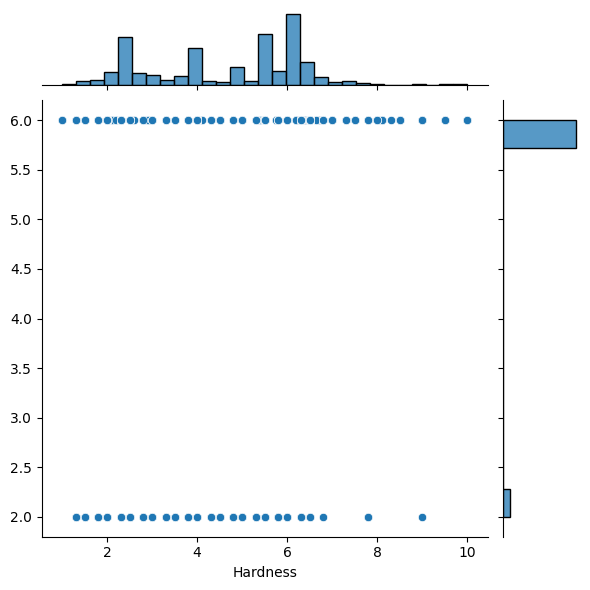

In [27]:
sns.jointplot(x=y_train, y=logr_pred)

# Run on X_test and y_test

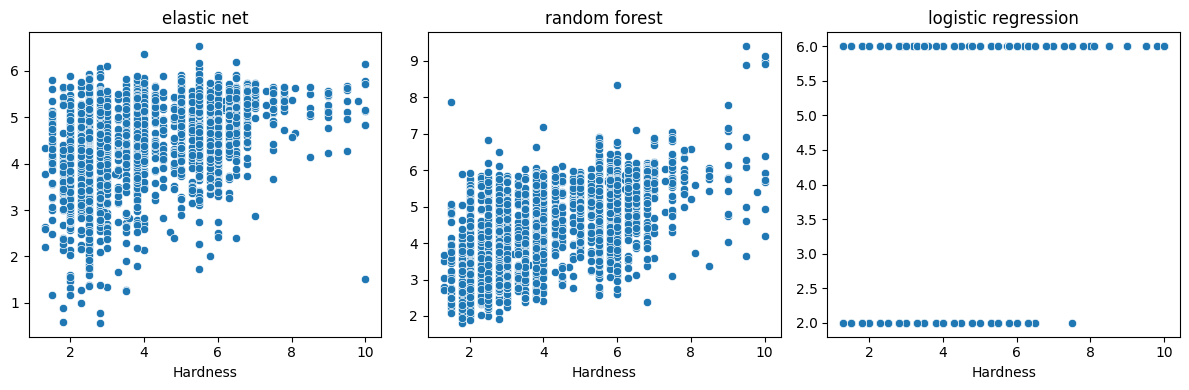

In [28]:
fig, axes = plt.subplots(1,3)
fig.set_figwidth(12)
fig.set_figheight(4)

sns.scatterplot(x=y_test, y=enet.predict(X_test), ax=axes[0])
sns.scatterplot(x=y_test, y=rfr.predict(X_test), ax=axes[1])
sns.scatterplot(x=y_test, y=logr.predict(X_test), ax=axes[2])


axes[0].set_title('elastic net')
axes[1].set_title('random forest')
axes[2].set_title('logistic regression')

plt.tight_layout()

In [29]:
print(f"enet {median_absolute_error(y_test, enet.predict(X_test))}")
print(f"rfr {median_absolute_error(y_test, rfr.predict(X_test))}")
print(f"logistic {median_absolute_error(y_test, logr.predict(X_test))}")

enet 0.9574857993453127
rfr 0.6450000000000036
logistic 0.7999999999999998


## Clean more stringently -- no zeros left

In [30]:
data_df_str=data_df.loc[(data_df==0).sum(axis=1)==0]

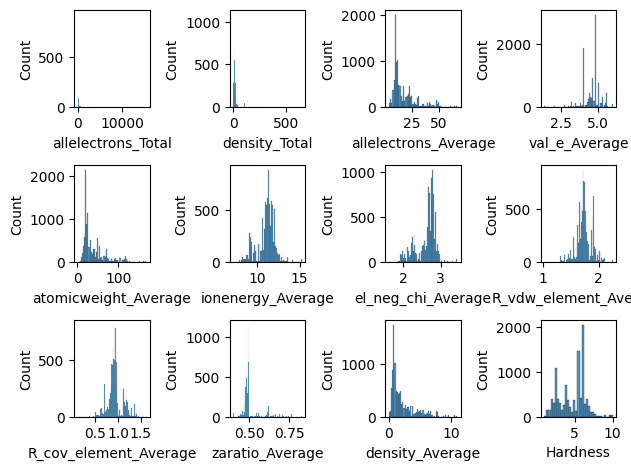

In [41]:
plot_histograms(data_df_str)

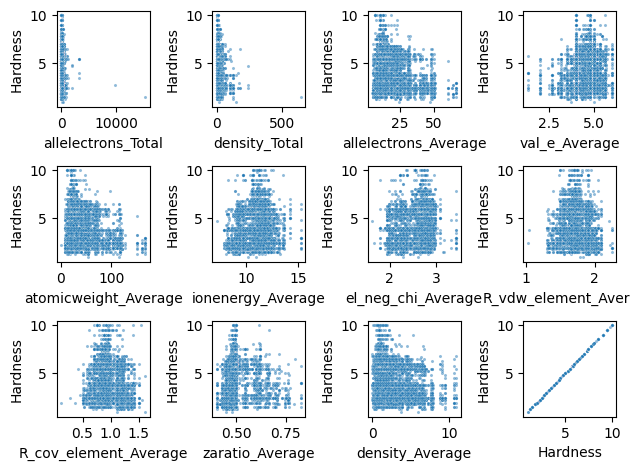

In [31]:
plot_scatter(data_df_str)

## RFR on stringent data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    data_df_str.drop('Hardness', axis=1), 
    data_df_str['Hardness'],
    test_size=0.33
)
print(f"number training samples: {len(y_train)}")
print(f"number test samples: {len(y_test)}")

number training samples: 6892
number test samples: 3395


In [33]:
params = {
    'n_estimators': [10, 100, 1000],
    'max_features': [None, 'sqrt', 'log2'],
}

rfr_s=GridSearchCV(
    estimator=RandomForestRegressor(
        oob_score=True
    ),
    param_grid=params, 
    cv=10,
    scoring='neg_median_absolute_error',
    n_jobs=2
)

rfr_s.fit(X_train, y_train)

/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 

GridSearchCV(cv=10, estimator=RandomForestRegressor(oob_score=True), n_jobs=2,
             param_grid={'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='neg_median_absolute_error')

<Axes: xlabel='param_n_estimators', ylabel='mean_test_score'>

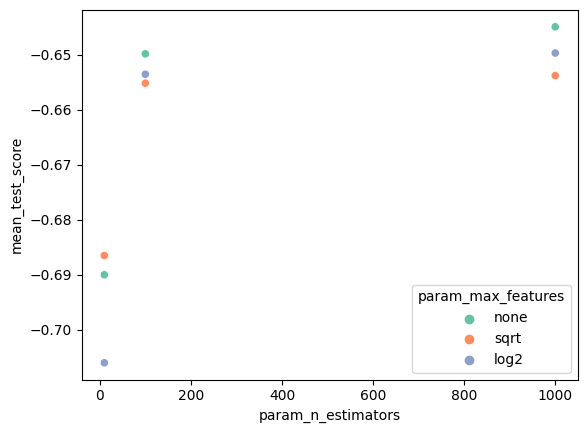

In [34]:
rfr_results=pd.DataFrame(rfr_s.cv_results_)
rfr_results.head()
rfr_results=rfr_results.fillna('none')

sns.scatterplot(
    x=rfr_results['param_n_estimators'],
    y=rfr_results['mean_test_score'],
    hue=rfr_results['param_max_features'],
    palette='Set2'
)

<Axes: xlabel='Hardness'>

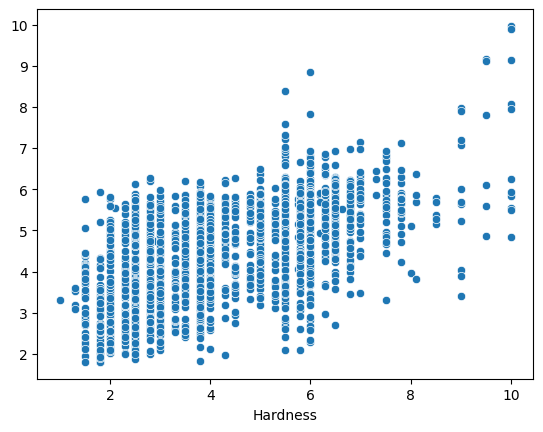

In [35]:
sns.scatterplot(
    x=y_test,
    y=rfr_s.predict(X_test)
)

In [36]:
median_absolute_error(y_test, rfr_s.predict(X_test))

0.6428999999999787

## Submit

In [37]:
test_data_df=pd.read_csv('test.csv', index_col='id')
test_data_df

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,,
10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...
17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425


In [38]:
pd.DataFrame({'id': test_data_df.index, 'Hardness': enet.predict(test_data_df)}).to_csv('sample_submission_enet_EMW.csv', index=None)
pd.DataFrame({'id': test_data_df.index, 'Hardness': rfr.predict(test_data_df)}).to_csv('sample_submission_rfr-1000_EMW.csv', index=None)
pd.DataFrame({'id': test_data_df.index, 'Hardness': rfr_s.predict(test_data_df)}).to_csv('sample_submission_rfr-100_EMW.csv', index=None)
pd.DataFrame({'id': test_data_df.index, 'Hardness': logr.predict(test_data_df)}).to_csv('sample_submission_logr_EMW.csv', index=None)

In [40]:
data_df_str.drop_duplicates()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8


## Ensemble

In [43]:
enet.predict(X_test)

array([5.22032197, 5.32271979, 4.66227415, ..., 4.4217521 , 5.472271  ,
       4.9966973 ])

In [46]:
comb_df = pd.DataFrame({
    'enet': enet.predict(X_test),
    'logr': logr.predict(X_test),
    'rfr_1000': rfr.predict(X_test),
    'rfr_100': rfr_s.predict(X_test),
    'hardness': y_test
})

/Users/erinwissink/.local/share/virtualenvs/age_test-8IGnYOvA/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


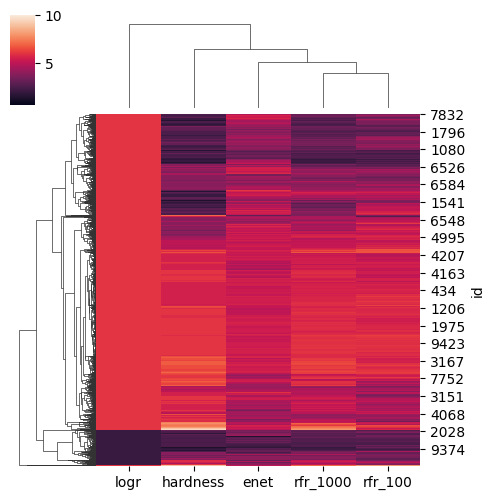

In [48]:
sns.clustermap(comb_df, figsize=(5,5))